In [1]:
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2024-05-27 22:34:41.839275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 22:34:42.217986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 22:34:42.219213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 22:34:43.318120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

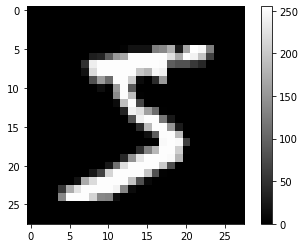

In [15]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [21]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))
lq.models.summary(model)

+sequential_7 stats----------------------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                               (bit)                        x 1       x 1    (kB)             |
+----------------------------------------------------------------------------------------------+
| quant_conv2d_12                   1  (-1, 25, 25, 32)      512         0    0.06      320000 |
| max_pooling2d_12                  -  (-1, 12, 12, 32)        0         0       0           0 |
| batch_normalization_25            -  (-1, 12, 12, 32)        0        64    0.25           0 |
| quant_conv2d_13                   1  (-1, 11, 11, 32)     4096         0    0.50      495616 |
| max_pooling2d_13                  -    (-1, 5, 5, 32)        0         0       0           0 |
| batch_normalization_26            -    (-1, 5, 5, 32)        0        64    0.25           0 |
| flatten_7                   

In [23]:
# Train NN
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=64, epochs=6)
test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/6
938/938 [==============================] - 6s 5ms/step - loss: 0.4713 - accuracy: 0.9660
Epoch 2/6
938/938 [==============================] - 5s 5ms/step - loss: 0.4727 - accuracy: 0.9657
Epoch 3/6
938/938 [==============================] - 5s 5ms/step - loss: 0.4691 - accuracy: 0.9673
Epoch 4/6
938/938 [==============================] - 5s 6ms/step - loss: 0.4680 - accuracy: 0.9678
Epoch 5/6
938/938 [==============================] - 5s 6ms/step - loss: 0.4664 - accuracy: 0.9679
Epoch 6/6
313/313 [==============================] - 0s 1ms/step - loss: 0.5933 - accuracy: 0.9416


In [12]:
# Extract weights
with lq.context.quantized_scope(True):
    weights = model.layers[0].get_weights()
    print(weights[0].shape)

binarized_weights = weights[0]
binarized_weights[binarized_weights == -1] = 0
print(weights[0].shape)
rows, cols, _, output_channels = weights[0].shape
print(rows, cols, output_channels)
for col in range(cols):
    for row in range(rows):
        for output_channel in range(output_channels):
            print(row, col, output_channel, weights[0][row][col][0][output_channel])

(4, 4, 1, 16)
(4, 4, 1, 16)
4 4 16
0 0 0 0.0
0 0 1 1.0
0 0 2 0.0
0 0 3 0.0
0 0 4 1.0
0 0 5 0.0
0 0 6 1.0
0 0 7 0.0
0 0 8 1.0
0 0 9 0.0
0 0 10 1.0
0 0 11 0.0
0 0 12 0.0
0 0 13 1.0
0 0 14 0.0
0 0 15 0.0
1 0 0 0.0
1 0 1 1.0
1 0 2 0.0
1 0 3 0.0
1 0 4 1.0
1 0 5 0.0
1 0 6 1.0
1 0 7 0.0
1 0 8 1.0
1 0 9 0.0
1 0 10 1.0
1 0 11 0.0
1 0 12 0.0
1 0 13 1.0
1 0 14 0.0
1 0 15 0.0
2 0 0 0.0
2 0 1 1.0
2 0 2 0.0
2 0 3 0.0
2 0 4 1.0
2 0 5 0.0
2 0 6 1.0
2 0 7 0.0
2 0 8 1.0
2 0 9 0.0
2 0 10 1.0
2 0 11 0.0
2 0 12 0.0
2 0 13 1.0
2 0 14 0.0
2 0 15 0.0
3 0 0 0.0
3 0 1 1.0
3 0 2 0.0
3 0 3 0.0
3 0 4 1.0
3 0 5 0.0
3 0 6 1.0
3 0 7 0.0
3 0 8 1.0
3 0 9 0.0
3 0 10 1.0
3 0 11 0.0
3 0 12 0.0
3 0 13 1.0
3 0 14 0.0
3 0 15 0.0
0 1 0 0.0
0 1 1 1.0
0 1 2 0.0
0 1 3 0.0
0 1 4 1.0
0 1 5 0.0
0 1 6 1.0
0 1 7 0.0
0 1 8 1.0
0 1 9 0.0
0 1 10 1.0
0 1 11 0.0
0 1 12 0.0
0 1 13 1.0
0 1 14 0.0
0 1 15 0.0
1 1 0 0.0
1 1 1 1.0
1 1 2 0.0
1 1 3 0.0
1 1 4 1.0
1 1 5 0.0
1 1 6 1.0
1 1 7 0.0
1 1 8 1.0
1 1 9 0.0
1 1 10 1.0
1 1 11 0.0
1 1 12 0.0
1 